(reservoir-amplitude-nonseq-ramping)=
# Amplitude and non-sequential ramping
This example shows how to apply amplitude ramping on reservoirs, which is licensed under the SHOP_NONSEQ_AMPLITUDE_RSV_RAMP license.

In [1]:
from pyshop import ShopSession
import pandas as pd
import plotly.graph_objs as go
import numpy as np
from amplitude_ramping import build_model, run_model

## Baseline run without ramping constraints
The system used in the example is a single reservoir above a plant with one generator:

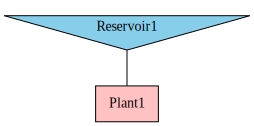

In [2]:
import os

shop = build_model()
shop.model.build_connection_tree()

The reservoir starts half full, and has a constant inflow of 50 m3/s from the 12th hour of the optimization horizon. The market price is above the constant water value in 4 hourly block where the middle one is the highest.

First, we run the model without any complex ramping constraints. The resulting reservoir level is shown below, and we see that SHOP will produce in the hours where the price is above the water value.

In [3]:
run_model(shop)

rsv = shop.model.reservoir["Reservoir1"]
level_no_ramp = rsv.head.get()
lrl = rsv.lrl.get()

fig = go.Figure()
fig.add_trace(go.Scatter(x=level_no_ramp.index, y=level_no_ramp.values, name="Reservoir level"))

fig.update_layout(title="Optimization without ramping constraints", xaxis_title="Time", yaxis_title="masl")

fig.show()

## Adding amplitude ramping constraint
Now we will add a 1 meter down amplitude ramping constraint over the whole period, which means the level should not go lower than 1 meter below the initial level.

In [4]:
shop = build_model()
rsv = shop.model.reservoir.Reservoir1
amplitude = 1 # meter
duration = 24*60 # minutes
starttime = shop.get_time_resolution()['starttime']
rsv.level_amplitude_ramping_limit_down.set([
    pd.Series(
        name=starttime,
        index=[duration], # duration from starttime in minutes
        data=[amplitude]
    )
])
run_model(shop)

level_no_ramp = rsv.head.get()
lrl = rsv.lrl.get()

fig = go.Figure()
fig.add_trace(go.Scatter(x=level_no_ramp.index, y=level_no_ramp.values, name="Reservoir level"))
fig.add_trace(go.Scatter(x=level_no_ramp.index, y=[94]*len(level_no_ramp),name="Ramping limit",line = dict(color = 'rgb(0, 0, 0)', dash = 'dash')))

fig.update_layout(title="Optimization with amplitude ramping constraints", xaxis_title="Time", yaxis_title="masl")

fig.show()

The results clearly show that the reservoir limit does not go below 94 meters, which is 1 meter below the initial level through the whole period. Note that the penalty for violating the limit must be set sufficient high.

## Non-sequential ramping
Unlike amplitude ramping, non-sequential ramping only requires that the final value respect the ramping limit. We apply the same data as previous case, but use non-sequential ramping instead:

In [5]:
shop = build_model()
rsv = shop.model.reservoir.Reservoir1
amplitude = 1 # meter
duration = 24*60 # minutes
starttime = shop.get_time_resolution()['starttime']
rsv.level_nonseq_ramping_limit_down.set([
    pd.Series(
        name=starttime,
        index=[duration], # duration from starttime in minutes
        data=[amplitude]
    )
])
run_model(shop)

level_no_ramp = rsv.head.get()
lrl = rsv.lrl.get()

fig = go.Figure()
fig.add_trace(go.Scatter(x=level_no_ramp.index, y=level_no_ramp.values, name="Reservoir level"))
fig.add_trace(go.Scatter(x=level_no_ramp.index, y=[94]*len(level_no_ramp),name="Ramping limit",line = dict(color = 'rgb(0, 0, 0)', dash = 'dash')))

fig.update_layout(title="Optimization with non-sequential ramping constraints", xaxis_title="Time", yaxis_title="masl")

fig.show()

The results shows that levels below the ramping limit is permitted as long as the end value is within the limit.